# Gym Mountain Car via TensorFlow 

Here is the one-dimensional game from OpenAi Gym which goal is get the car on the mountain https://gym.openai.com/envs/MountainCar-v0/ The car is not powerful enough to scale the mountain in a single pass. So we need to drive it back and forth to build up momentum. To solve this task we going to build a simple neural network with TensorFlow.

In [ ]:
#install and load libraries
!pip install tensorflow-cpu
!pip install gym
!pip install keras
!pip install keras-rl2

In [ ]:
!pip install pygame

In [ ]:
!pip install imageio-ffmpeg

In [ ]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gym 
import random

In [ ]:
import math

In [ ]:
import pygame
from pygame import gfxdraw

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
from gym.envs.classic_control import  MountainCarEnv
from gym import spaces
from typing import Optional

In [ ]:
#create custom environment
class MountainCarEnv(gym.Env):
    
    def __init__(self, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.force = 0.001
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.screen = None
        self.clock = None
        self.isopen = True

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        done = bool(position >= self.goal_position and velocity >= self.goal_velocity)
        if position >= self.goal_position: #set a higher score for reaching the goal position
            reward = 100
            
        elif self.goal_position > position >= 0.04: #also set a reward for almost reaching the goal position
            reward = 5
        
        else:
            reward = -0.0001  #and negative reward for other cases
        

        self.state = (position, velocity)
        return np.array(self.state, dtype=np.float32), reward, done, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.state = np.array([self.np_random.uniform(low=-0.6, high=-0.4), 0])
        if not return_info:
            return np.array(self.state, dtype=np.float32)
        else:
            return np.array(self.state, dtype=np.float32), {}

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self, mode="human"):
        screen_width = 600
        screen_height = 400

        world_width = self.max_position - self.min_position
        scale = screen_width / world_width
        carwidth = 40
        carheight = 20
        if self.screen is None:
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((screen_width, screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((screen_width, screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 50
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if mode == "human":
            pygame.event.pump()
#             self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        if mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )
        else:
            return self.isopen

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [ ]:
#set an environment
env = MountainCarEnv()
states = env.observation_space.shape[0]
actions = env.action_space.n
# env.render()

In [ ]:
#check number of actions and states
actions

3

In [ ]:
states

2

In [ ]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [ ]:
#build a model
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 2)                 0         
                                                                 
 dense_15 (Dense)            (None, 24)                72        
                                                                 
 dense_16 (Dense)            (None, 24)                600       
                                                                 
 dense_17 (Dense)            (None, 3)                 75        
                                                                 
Total params: 747
Trainable params: 747
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# build an agent
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
#train the agent
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=20000, visualize=True, verbose=1)

Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: 0.3724
11 episodes - episode_reward: 338.551 [179.962, 749.494] - loss: 1.155 - mae: 4.707 - mean_q: 7.149

Interval 2 (10000 steps performed)
 2015/10000 [=====>........................] - ETA: 1:12 - reward: 0.9007done, took 109.696 seconds


In [ ]:
#test the agent
scores = dqn.test(env, nb_episodes=5, visualize=True)
print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: 164.990, steps: 118
Episode 2: reward: 154.989, steps: 118
Episode 3: reward: 174.990, steps: 117
Episode 4: reward: 249.982, steps: 207
Episode 5: reward: 159.989, steps: 118
180.98815999999994


<AxesSubplot:>

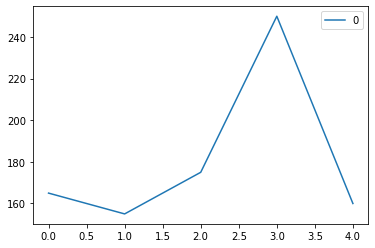

In [ ]:
pd.DataFrame(scores.history['episode_reward']).plot()

Agent is succesfull enough. Check the video https://youtu.be/qcU7YvZYKe4

In [ ]:
#save agent weights
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
#record the video
from gym.wrappers import RecordVideo
env = RecordVideo(gym.make('MountainCar-v0'), 'MC_video')
_ = dqn.test(env, nb_episodes=15, visualize=True)

C:\Users\Ruslan\anaconda3\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at C:\Users\Ruslan\MC_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Testing for 15 episodes ...
Episode 1: reward: -117.000, steps: 117
Episode 2: reward: -117.000, steps: 117
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -119.000, steps: 119
Episode 5: reward: -117.000, steps: 117
Episode 6: reward: -118.000, steps: 118
Episode 7: reward: -116.000, steps: 116
Episode 8: reward: -130.000, steps: 130
Episode 9: reward: -118.000, steps: 118
Episode 10: reward: -200.000, steps: 200
Episode 11: reward: -119.000, steps: 119
Episode 12: reward: -116.000, steps: 116
Episode 13: reward: -200.000, steps: 200
Episode 14: reward: -118.000, steps: 118
Episode 15: reward: -200.000, steps: 200


In [ ]:
env.close()

# Conclusion

In this video https://youtu.be/qcU7YvZYKe4 we can see how our simple model easily handles the task. It also needs to be said that our solution has some downsides. As you remember we've set a 5 score reward for almost achieving the goal (position = 0.4). It stimulates agent to drive forward, but it also can end up skidding before it reaches the mountain tip to get much scores (like here https://youtu.be/LCGJdc-wP24).